This validation case is NRA measurements of D in self-damaged W performed by [S. Markelj et al.](https://www.sciencedirect.com/science/article/pii/S0022311515303470?via%3Dihub)

The experimental procedure included three main phases. A high-purity polycrystalline W sample of 0.8 mm thickness was pre-damaged with 20 MeV W ions. The pre-damaged sample was then exposed to low-energy (~0.3 eV) D atomic flux of $5.8\times 10^{18}\,\textrm{m}^{-2}\textrm{s}^{-1}$ at 600 K. The exposure continued until the D fluence of $1\times 10^{24}\,\mathrm{m}^{-2}$ was reached. Finally, an isothermal desorption of D for 43 h. at 600 K was conducted. 

The FESTIM model is based on the approach of [E.A. Hodille et al.](https://iopscience.iop.org/article/10.1088/1741-4326/aa5aa5/meta) Only isothermal D exposure and desorption phases are simulated omitting intermediate cooling/re-heating steps. For the surface processes, adsorption of low-energy atoms, desorption of molecules (Langmuir-Hinshelwood recombination), and recombination of an adsorbed atom with an incident atom (Eley-Rideal recombination) are considered.

The D diffusivity in W is defined by scaling the corresponding value for H ([N. Fernandez et al.](https://www.sciencedirect.com/science/article/pii/S1359645415003043)) by a factor of $1/\sqrt{2}$. Five types of trapping sites are included to reproduce the experimental data: two intrinsic traps and three extrinsic traps with sigmoidal distribution ($f$) within the damaged layer:

$$
f(x)=\dfrac{1}{1+\exp\left(\dfrac{x-x_0}{\Delta x}\right)},
$$
where $x_0=2.2\,\mu\textrm{m}$, $\Delta x=0.154\,\mu\textrm{m}$.

The FESTIM results are compared to the experimental data and the results of MHIMS simulation, both taken from [E.A. Hodille et al 2017 Nucl. Fusion 57 056002](https://iopscience.iop.org/article/10.1088/1741-4326/aa5aa5/meta).

## FESTIM model

In [1]:
import festim as F
import fenics as f
import numpy as np
import sympy as sp
import h_transport_materials as htm

################### PARAMETERS ###################
# Exposure conditions
Gamma_atom = 5.8e18
T_exposure = 600
t_exposure = 1e24 / Gamma_atom
t_des = 52 * 3600
final_time = t_exposure + t_des

# Sample
L = 0.8e-3  # half thickness, m

# W properties
rho_W = 6.3e28  # W atomic concentration, m^-3
n_IS = 6 * rho_W  # concentration of interstitial sites, m^-3
n_surf = 6.9 * rho_W ** (2 / 3)  # concentration of adsorption sites, m^-2
nu0 = 1e13  # attempt frequency, s^-1
SP = 0.19

D_H = htm.diffusivities.filter(material=htm.Tungsten, author="fernandez")[0]
D0 = D_H.pre_exp.magnitude / np.sqrt(2)  # diffusivity pre-factor, m^2 s^-1
E_diff = D_H.act_energy.magnitude  # diffusion activation energy, eV

lambda_IS = 110e-12  # distance between 2 IS sites, m
sigma_exc = 1.7e-21  # Cross-section for the direct abstraction, m^2
lambda_des = 1 / np.sqrt(n_surf)

# Transitions
E_bs = E_diff  # energy barrier from bulk to surface, eV
E_sb = 1.545
E_des = 0.87


################### FUNCTIONS ###############
def k_sb(T, surf_conc, solute_conc, t):
    return nu0 * f.exp(-E_sb / F.k_B / T)


def k_bs(T, surf_conc, solute_conc, t):
    return nu0 * f.exp(-E_bs / F.k_B / T) * n_surf / n_IS


def J_vs_left(T, surf_conc, solute_conc, t):
    G_atom = Gamma_atom * f.conditional(t <= t_exposure, 1, 0)

    phi_atom = SP * G_atom * (1 - surf_conc / n_surf)

    phi_exc = G_atom * sigma_exc * surf_conc

    phi_des = 2 * nu0 * (lambda_des * surf_conc) ** 2 * f.exp(-2 * E_des / F.k_B / T)
    return phi_atom - phi_exc - phi_des


def J_vs_right(T, surf_conc, solute_conc, t):
    phi_des = 2 * nu0 * (lambda_des * surf_conc) ** 2 * f.exp(-2 * E_des / F.k_B / T)
    return -phi_des


################### MODEL ###################

W_model = F.Simulation(log_level=40)

# Mesh
vertices = np.concatenate(
    [
        np.linspace(0, 5e-8, num=100),
        np.linspace(5e-8, 5e-6, num=200),
        np.linspace(5e-6, L, num=500),
    ]
)

W_model.mesh = F.MeshFromVertices(vertices)

# Materials
tungsten = F.Material(id=1, D_0=D0, E_D=E_diff)
W_model.materials = tungsten

distr = 1 / (1 + sp.exp((F.x - 2.2e-6) / 1.54e-7))

traps = F.Traps(
    [
        F.Trap(
            k_0=D0 / (n_IS * lambda_IS**2),
            E_k=E_diff,
            p_0=nu0,
            E_p=0.85,
            density=1e-4 * rho_W,
            materials=tungsten,
        ),
        F.Trap(
            k_0=D0 / (n_IS * lambda_IS**2),
            E_k=E_diff,
            p_0=nu0,
            E_p=1.00,
            density=1e-4 * rho_W,
            materials=tungsten,
        ),
        F.Trap(
            k_0=D0 / (n_IS * lambda_IS**2),
            E_k=E_diff,
            p_0=nu0,
            E_p=1.65,
            density=0.19e-2 * rho_W * distr,
            materials=tungsten,
        ),
        F.Trap(
            k_0=D0 / (n_IS * lambda_IS**2),
            E_k=E_diff,
            p_0=nu0,
            E_p=1.85,
            density=0.16e-2 * rho_W * distr,
            materials=tungsten,
        ),
        F.Trap(
            k_0=D0 / (n_IS * lambda_IS**2),
            E_k=E_diff,
            p_0=nu0,
            E_p=2.06,
            density=0.02e-2 * rho_W * distr,
            materials=tungsten,
        ),
    ]
)
W_model.traps = traps

W_model.T = T_exposure

BC_left = F.SurfaceKinetics(
    k_sb=k_sb,
    k_bs=k_bs,
    lambda_IS=lambda_IS,
    n_surf=n_surf,
    n_IS=n_IS,
    J_vs=J_vs_left,
    surfaces=1,
    initial_condition=0,
    t=F.t,
)

BC_right = F.SurfaceKinetics(
    k_sb=k_sb,
    k_bs=k_bs,
    lambda_IS=lambda_IS,
    n_surf=n_surf,
    n_IS=n_IS,
    J_vs=J_vs_right,
    surfaces=2,
    initial_condition=0,
    t=F.t,
)

W_model.boundary_conditions = [BC_left, BC_right]

# Exports
export_fluences = [
    5.22e22,
    1.25e23,
    4.8e23,
    6.3e23,
    1e24,
]

export_times = [fluence / Gamma_atom for fluence in export_fluences]

export_times += [export_times[-1] + 20 * 3600, export_times[-1] + 52 * 3600]

derived_quantities = F.DerivedQuantities(
    [
        F.TotalVolume(field="retention", volume=1),
        F.AdsorbedHydrogen(surface=1),
        F.AdsorbedHydrogen(surface=2),
    ],
    show_units=True,
)

TXT = F.TXTExport(field="retention", filename="./FESTIM_sim.txt", times=export_times)

W_model.exports = [derived_quantities] + [TXT]

W_model.dt = F.Stepsize(
    initial_value=1e-5,
    stepsize_change_ratio=1.25,
    max_stepsize=500,
    dt_min=1e-6,
    milestones=export_times,
)

W_model.settings = F.Settings(
    absolute_tolerance=1e7,
    relative_tolerance=1e-13,
    final_time=final_time,
    traps_element_type="DG",
)

W_model.initialise()
W_model.run()

Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...
100.0 %        3.6e+05 s    Elapsed time so far: 68.9 s


# Comparison

In [2]:
import matplotlib.pyplot as plt


def add_arrow(axis, x1, y1, x2, y2):
    axis.annotate(
        "",
        xy=(x1, y1),
        xytext=(x2, y2),
        xycoords="data",
        arrowprops=dict(
            arrowstyle="<|-",
            connectionstyle="arc3,rad=0",
            linestyle="solid",
            lw=1.5,
            color="grey",
            alpha=0.75,
        ),
        zorder=0,
    )


mpl_params = {
    "text.usetex": True,
    "text.latex.preamble": "\n".join(
        [
            r"\usepackage{siunitx}",
            r"\sisetup{detect-all}",
            r"\usepackage{amsmath}",
            r"\usepackage[utf8]{inputenc}",
            r"\usepackage[russian]{babel}",
            r"\usepackage{bm}",
        ]
    ),
    "axes.spines.right": False,
    "axes.spines.top": False,
    "font.family": "Times New Roman",
    "font.size": 12,
    "legend.frameon": False,
}
plt.rcParams.update(mpl_params)

mm2inch = 0.1 / 2.54

FESTIM reproduces the results of NRA measurements and agrees well with MHIMS

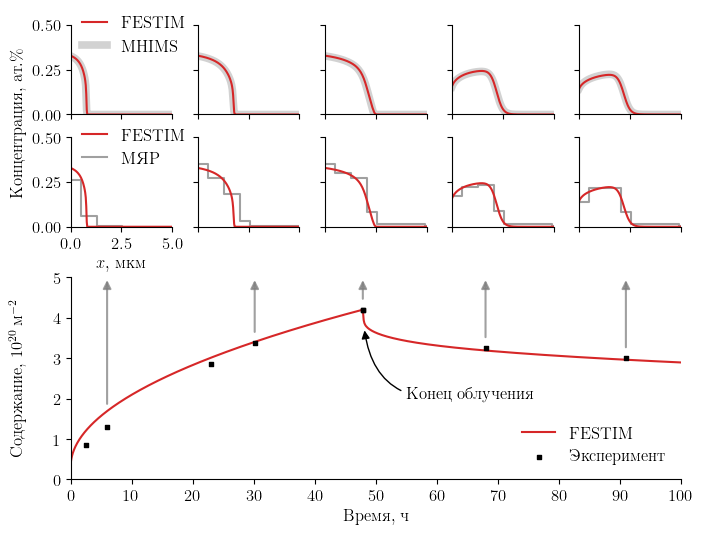

In [3]:
fig = plt.figure(figsize=(200 * mm2inch, 150 * mm2inch))
gs = fig.add_gridspec(2, 1, height_ratios=[1, 1], hspace=0.25)
gs0 = gs[0].subgridspec(2, 5, hspace=0.25, wspace=0.25)
gs1 = gs[1].subgridspec(1, 1, hspace=0.0)

axs_top_mid = gs0.subplots(sharey=True)
axs_top = axs_top_mid[0, :]
axs_mid = axs_top_mid[1, :]
axs_bot = gs1.subplots()

retention = (
    np.array(derived_quantities[0].data)
    + np.array(derived_quantities[1].data)
    + np.array(derived_quantities[2].data)
)
t = np.array(derived_quantities.t)

axs_bot.plot(t / 3600, retention / 1e20, label="FESTIM", color="tab:red", lw=1.5)

MHIMS_profiles = np.loadtxt(
    "./reference_data/MHIMS_profiles.csv", delimiter=",", skiprows=1
)

exp_ret = np.loadtxt("./reference_data/exp_ret.csv", delimiter=",", skiprows=1)
axs_bot.scatter(
    exp_ret[:, 0],
    exp_ret[:, 1] / 1e20,
    s=12,
    label="Эксперимент",
    color="black",
    zorder=2,
    marker="s",
)

FESTIM_profiles = np.genfromtxt("./FESTIM_sim.txt", names=True, delimiter=",")
NRA_exp = np.loadtxt("./reference_data/exp_NRA.csv", delimiter=",", skiprows=1)
NRA_sto = np.loadtxt("./reference_data/sto_NRA.csv", delimiter=",", skiprows=1)

export_times = [
    1.25e23 / Gamma_atom,
    6.3e23 / Gamma_atom,
    1e24 / Gamma_atom,
    1e24 / Gamma_atom + 20 * 3600,
    1e24 / Gamma_atom + 52 * 3600,
]

for i, t in enumerate(export_times):
    x = FESTIM_profiles["x"]
    y = FESTIM_profiles[f"t{t:.2e}s".replace(".", "").replace("+", "")]
    # order y by x
    x, y = zip(*sorted(zip(x, y)))

    axs_top[i].plot(
        np.array(x) / 1e-6,
        np.array(y) / rho_W * 100,
        lw=1.5,
        color="tab:red",
        label="FESTIM",
    )

    axs_mid[i].plot(
        np.array(x) / 1e-6,
        np.array(y) / rho_W * 100,
        lw=1.5,
        color="tab:red",
        label="FESTIM",
    )

NRA_kwargs = {"label": "МЯР", "lw": 1.5, "zorder": 0, "color": "grey", "alpha": 0.75}

MHIMS_kwargs = {
    "color": "grey",
    "alpha": 0.35,
    "label": "MHIMS",
    "lw": 5.5,
    "zorder": 0,
}
axs_top[0].plot(MHIMS_profiles[:, 0], MHIMS_profiles[:, 2], **MHIMS_kwargs)

for i in range(1, 5):
    axs_top[i].plot(MHIMS_profiles[:, 0], MHIMS_profiles[:, i + 3], **MHIMS_kwargs)

axs_mid[0].plot(NRA_exp[:, 0], NRA_exp[:, 2], **NRA_kwargs)
axs_mid[1].plot(NRA_exp[:, 0], NRA_exp[:, 4], **NRA_kwargs)
axs_mid[2].plot(NRA_exp[:, 0], NRA_exp[:, 5], **NRA_kwargs)
axs_mid[3].plot(NRA_sto[:, 0], NRA_sto[:, 1], **NRA_kwargs)
axs_mid[4].plot(NRA_sto[:, 0], NRA_sto[:, 2], **NRA_kwargs)

for i in range(len(axs_top)):
    if i == 0:
        axs_mid[i].set_xticks([0, 2.5, 5])
        axs_mid[i].set_xlabel(r"$x$, мкм")
        axs_top[i].tick_params(which="both", labelbottom=False)
    else:
        axs_top[i].tick_params(which="both", labelbottom=False)
        axs_mid[i].tick_params(which="both", labelbottom=False)
    axs_mid[i].set_xlim(0, 5)
    axs_mid[i].set_ylim(0, 0.5)
    axs_mid[i].set_yticks([0, 0.25, 0.50])
    axs_top[i].set_xlim(0, 5)
    axs_top[i].set_ylim(0, 0.5)
    axs_top[i].set_yticks([0, 0.25, 0.50])


axs_top[0].legend(handlelength=1.5, loc=(0.05, 0.6))
axs_mid[0].legend(handlelength=1.5, loc=(0.05, 0.6))
axs_top[0].set_xlim(0, 5)
axs_top[0].set_ylim(0, 0.5)
axs_mid[0].set_xlim(0, 5)
axs_mid[0].set_ylim(0, 0.5)
axs_mid[0].set_ylabel(r"Концентрация, ат.$\%$", y=1.15)

axs_bot.set_xlabel(r"Время, ч")
axs_bot.set_ylabel(r"Содержание, $10^{20}\,\text{м}^{-2}$")
axs_bot.legend(frameon=False, loc="lower right")
axs_bot.set_ylim(0, 5)
axs_bot.set_xlim(0, 100)
axs_bot.set_xticks([i for i in range(0, 110, 10)])

add_arrow(axs_bot, exp_ret[1, 0], exp_ret[1, 1] / 1e20 + 0.5, exp_ret[1, 0], 5)
add_arrow(axs_bot, exp_ret[3, 0], exp_ret[3, 1] / 1e20 + 0.2, exp_ret[3, 0], 5)
add_arrow(axs_bot, exp_ret[7, 0], exp_ret[7, 1] / 1e20 + 0.2, exp_ret[7, 0], 5)
add_arrow(axs_bot, exp_ret[4, 0], exp_ret[4, 1] / 1e20 + 0.2, exp_ret[4, 0], 5)
add_arrow(axs_bot, exp_ret[6, 0], exp_ret[6, 1] / 1e20 + 0.2, exp_ret[6, 0], 5)

axs_bot.annotate(
    "Конец облучения",
    xy=(exp_ret[4, 0], exp_ret[4, 1] / 1e20),
    xytext=(55, 2),
    xycoords="data",
    arrowprops=dict(
        arrowstyle="-|>",
        connectionstyle="arc3,rad=-0.6",
        linestyle="solid",
        lw=1,
        color="black",
        shrinkB=-15,
    ),
    zorder=0,
)

fig.align_ylabels()

plt.savefig("../../../Thesis/images/val3.pdf", bbox_inches="tight", pad_inches=0.02)
plt.show()

We can evaluate RMSE between simulation and experimental results 

In [4]:
from scipy.interpolate import interp1d


def RMSE(x_sim, x_exp):
    error = np.sqrt(np.mean((x_sim - x_exp) ** 2))
    return error


retention = (
    np.array(derived_quantities[0].data)
    + np.array(derived_quantities[1].data)
    + np.array(derived_quantities[2].data)
)
t = np.array(derived_quantities.t)

interp_ret = interp1d(t / 3600, retention, fill_value="extrapolate")

error = RMSE(
    interp_ret(
        exp_ret[:, 0],
    ),
    exp_ret[:, 1],
)

print(f"RMSE in retention values is {error:.3e} 1/m^2")

RMSE in retention values is 2.060e+19 1/m^2
